In [3]:
!pip install PyPortfolioOpt
!pip install portfolio-backtest
!pip install riskfolio-lib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 12.0 MB/s eta 0:00:00


In [4]:
#Grab Data
import yfinance as yf


import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import riskfolio as rp

**Risk parity Portfolio**

In [114]:
def rolling_rp_optimization(i, j, k, start_date, end_date, tickers):
    try:
        # Vérification des paramètres d'entrée
        if j < i:
            raise ValueError("Le deuxième paramètre (j) doit être supérieur au premier (i).")
    except ValueError as e:
        print(f"Erreur d'entrée : {e}")
        return

    # Étape 1 : Récupérer les données
    try:
        #tickers = ['SPHQ', 'IVE', 'SPYD', 'LOWV.L', 'SPMO']
        #start_date = '2020-01-01'
        #end_date = '2023-12-31'

        data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
        returns = data.pct_change().dropna()

        spy_data = yf.download('SPY', start=start_date, end=end_date)['Adj Close']
        spy_returns = spy_data.pct_change().dropna()
    except Exception as e:
        print(f"Erreur lors de la récupération des données : {e}")
        return

    # Étape 2 : Initialisation des variables
    try:
        train_data = returns.iloc[:j, :]
        test_data = returns.iloc[j:, :]
        spy_test_data = spy_returns.iloc[j:]
        metrics_list = []
        start_idx = 0
        n_slices = len(test_data) // k
        weights_mat = []
        ptf_returns=[]
    except Exception as e:
        print(f"Erreur lors de l'initialisation des variables : {e}")
        return

    # Étape 3 : Optimisation RP pour chaque tranche
    try:
        while start_idx + i <= len(test_data) and start_idx + i <= len(spy_test_data) :
            # Découpage des données de test
            slice_data = test_data.iloc[start_idx:start_idx + i]
            spy_slice_data = spy_test_data.iloc[start_idx:start_idx + i].to_numpy().flatten()


            # Optimisation RP sur les données d'entraînement actuelles
            port = rp.Portfolio(returns=train_data)
            port.assets_stats(method_mu='hist', method_cov='hist')
            weights = port.rp_optimization(model='Classic', rm='MV').to_numpy().flatten()
            weights_mat.append(weights)


            # Calcul des rendements du portefeuille pour la tranche
            portfolio_returns = slice_data @ weights
            ptf_returns.extend(portfolio_returns)

            # Calcul des métriques
            cov_matrix = np.cov(portfolio_returns, spy_slice_data)
            beta = cov_matrix[0, 1] / cov_matrix[1, 1]
            expected_annual_return = float(portfolio_returns.mean() * 252)

            annual_volatility = float(portfolio_returns.std() * np.sqrt(252))
            sharpe_ratio = float(expected_annual_return / annual_volatility)
            treynor_ratio = float(expected_annual_return / beta)
            cumulative_return = float((1 + portfolio_returns).prod() - 1)


            metrics_list.append({
                "Slice": len(metrics_list) + 1,
                "Expected Annual Return": expected_annual_return,
                "Annual Volatility": annual_volatility,
                "Sharpe Ratio": sharpe_ratio,
                "Treynor Ratio": treynor_ratio,
                "Cumulative Return": cumulative_return
            })

            # Mise à jour des données d'entraînement
            train_data = pd.concat([train_data, slice_data.iloc[:k]]).iloc[-j:]
            start_idx += k
    except Exception as e:
        print(f"Erreur lors de l'optimisation ou du calcul des métriques : {e}")
        return

    # Étape 4 : Conversion en DataFrame
    try:
        metrics_df = pd.DataFrame(metrics_list)
        metrics_df = metrics_df.set_index("Slice")
    except KeyError as e:
        print(f"Erreur lors de la conversion en DataFrame : {e}")
        return
    except Exception as e:
        print(f"Erreur inattendue : {e}")
        return

    return metrics_df, np.array(ptf_returns), weights_mat

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
start_date = '2013-01-01'
end_date = '2024-10-31'
tickers = ['SPHQ', 'IVE', 'SPYD', 'SPLV', 'SPMO']
metrics={}
#for i in [1,2,3,4,5]:
#  for j in [5,10,22,44,66,126,252]:
#for i,j in [(22,66)]:
#for i,j in zip([2,2,2,3,3,3,5,5,5,10,10,22,22], [5,22,66,5,22,66,5,22,66,22,66,22,66]):
for i,j in zip([44,44,66,126,252], [66,126,126,252,252]):
  metrics[(i,j)]= rolling_rp_optimization(i=i, j=j, k=i, start_date=start_date, end_date=end_date, tickers=tickers)

In [ ]:
#for i,j in zip([2,2,2,3,3,3,5,5,5,10,10,22,22], [5,22,66,5,22,66,5,22,66,22,66,22,66]):
for i,j in zip([44,44,66,126,252], [66,126,126,252,252]):
  print(f"i={i}, j={j}, return={((1+metrics[(i,j)][0]['Cumulative Return']).prod()-1)*100:.2f}%, average volatility={metrics[(i,j)][0]['Annual Volatility'].mean()*100:.2f}%, average sharpe ratio={metrics[(i,j)][0]['Sharpe Ratio'].mean():.2f}, volatility={metrics[(i,j)][0]['Cumulative Return'].std()*100*np.sqrt(252/i):.2f}%, sharpe ratio={((1+metrics[(i,j)][0]['Cumulative Return']).prod()-1)/(metrics[(i,j)][0]['Cumulative Return'].std()*np.sqrt(252/i)):.2f}, true return={((1+np.array(metrics[(i,j)][2])).prod()-1)*100:.2f}%, true volatility={np.array(metrics[(i,j)][2]).std()*100*np.sqrt(252):.2f}%, true sharpe ratio={(((1+np.array(metrics[(i,j)][2])).prod()-1)/(np.array(metrics[(i,j)][2]).std()*np.sqrt(252))):.2f}")

**Equal weight portfolio**

In [115]:
def rolling_equal_weight_BT(i, j,k, start_date, end_date, tickers):
    if j < i:
        raise ValueError("Le deuxième paramètre (j) doit être supérieur au premier (i)")

    #start_date = '2020-01-01'
    #end_date = '2023-12-31'

    #tickers = ['SPHQ', 'IVE', 'SPYD', 'LOWV.L', 'SPMO']
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    returns = data.pct_change().dropna()

    spy_data = yf.download('SPY', start=start_date, end=end_date)['Adj Close']
    spy_returns = spy_data.pct_change().dropna()

    # Initialisation des variables
    train_data = returns.iloc[:j, :]
    test_data = returns.iloc[j:, :]
    spy_test_data = spy_returns.iloc[j:]
    metrics_list = []
    start_idx = 0
    n_slices = len(test_data) // k  # Nombre de tranches
    ptf_returns=[]

    while start_idx + i <= len(test_data) and start_idx + i <= len(spy_test_data) :
        # Étape 3 : Découpage des données
        slice_data = test_data.iloc[start_idx:start_idx + i]
        spy_slice_data = spy_test_data.iloc[start_idx:start_idx + i].to_numpy().flatten()


        # Portefeuille également pondéré (Equal Weight)
        equal_weights = np.ones(slice_data.shape[1]) / slice_data.shape[1]
        portfolio_returns_equal_weight = slice_data.dot(equal_weights)
        ptf_returns.extend(portfolio_returns_equal_weight)

        # Calcul des métriques
        expected_annual_return = float(portfolio_returns_equal_weight.mean() * 252)
        annual_volatility = float(portfolio_returns_equal_weight.std() * np.sqrt(252))
        sharpe_ratio = float(expected_annual_return / annual_volatility)
        cumulative_return = float((1 + portfolio_returns_equal_weight).prod() - 1)

        metrics_list.append({
            "Slice": len(metrics_list) + 1,
            "Expected Annual Return (Equal Weight)": expected_annual_return,
            "Annual Volatility (Equal Weight)": annual_volatility,
            "Sharpe Ratio (Equal Weight)": sharpe_ratio,
            "Cumulative Return (Equal Weight)": cumulative_return
        })

        # Mise à jour des données d'entraînement
        train_data = pd.concat([train_data, slice_data.iloc[:k]]).iloc[-j:]  # Ajouter la tranche, supprimer les anciennes données
        start_idx += k

    # Convertir les métriques en DataFrame
    metrics_df = pd.DataFrame(metrics_list).set_index("Slice")
    return metrics_df, np.array(ptf_returns)


**Market BT**

In [116]:
import yfinance as yf
import numpy as np
import pandas as pd

def rolling_backtest_SPY(i, j, k, start_date, end_date):
    try:
        if j < i:
            raise ValueError("Le deuxième paramètre (j) doit être supérieur au premier (i).")
    except ValueError as e:
        print(f"Erreur d'entrée : {e}")
        return

    # Étape 1 : Récupérer les données de SPY
    try:
        #start_date = '2020-01-01'
        #end_date = '2023-12-31'
        spy_data = yf.download('SPY', start=start_date, end=end_date)['Adj Close']
        spy_returns = spy_data.pct_change().dropna()
        print("Données récupérées avec succès.")
    except Exception as e:
        print(f"Erreur lors de la récupération des données : {e}")
        return

    # Étape 2 : Initialisation des variables
    try:
        train_data = spy_returns.iloc[:j]
        test_data = spy_returns.iloc[j:]
        spy_test_data = spy_returns.iloc[j:] #yohann a ajouté cette ligne
        metrics_list = []
        start_idx = 0
        n_slices = len(test_data) // k  # Nombre de tranches
        ptf_returns=[]
        print("Initialisation terminée.")
    except Exception as e:
        print(f"Erreur lors de l'initialisation des variables : {e}")
        return

    # Étape 3 : Backtest pour chaque tranche
    try:
        while start_idx + i <= len(test_data) and start_idx + i <= len(spy_test_data) :

            # Découper les données de test
            slice_data = test_data.iloc[start_idx:start_idx + i]


            # Calcul des rendements du portefeuille (ici, on prend directement SPY comme portefeuille)
            portfolio_returns = slice_data
            ptf_returns.extend(portfolio_returns.values)

            # Calcul des métriques
            expected_annual_return = float(portfolio_returns.mean() * 252)
            annual_volatility = float(portfolio_returns.std() * np.sqrt(252))
            sharpe_ratio = float(expected_annual_return / annual_volatility)
            cumulative_return = float((1 + portfolio_returns).prod() - 1)

            metrics_list.append({
                "Slice": len(metrics_list) + 1,
                "Expected Annual Return": expected_annual_return,
                "Annual Volatility": annual_volatility,
                "Sharpe Ratio": sharpe_ratio,
                "Cumulative Return": cumulative_return
            })

            # Mise à jour des données d'entraînement
            train_data = pd.concat([train_data, slice_data.iloc[:k]]).iloc[-j:]
            start_idx += k
        print("Calcul des métriques terminé.")

    except Exception as e:
        print(f"Erreur lors du backtest ou du calcul des métriques : {e}")
        return

    # Étape 4 : Conversion des métriques en DataFrame
    try:
        metrics_df = pd.DataFrame(metrics_list).set_index("Slice")
        print("Métriques converties en DataFrame.")
    except Exception as e:
        print(f"Erreur lors de la conversion en DataFrame : {e}")
        return

    return metrics_df, np.array(ptf_returns)


In [ ]:
start_date = '2020-01-01'
end_date = '2023-12-31'
for i in [5,10,22,44]:
  for j in [22,44,66,126,252]:
    if(i<=j):
      metrics = rolling_backtest_SPY(i=i, j=j, k=i, start_date=start_date, end_date=end_date)
      if metrics is None:
        print(i,j)
      else:
        print(f"i={i}, j={j}, return={((1+metrics['Cumulative Return']).prod()-1)*100:.2f}%, average volatility={metrics['Annual Volatility'].mean()*100:.2f}%, average sharpe ratio={metrics['Sharpe Ratio'].mean():.2f}")

**Min-Var**

In [117]:
import yfinance as yf
import numpy as np
import pandas as pd
import pypfopt as pf


def download_data(tickers, start_date, end_date):
    """Télécharge les données de clôture ajustée et retourne les rendements."""
    try:
        data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
        returns = data.pct_change().dropna()
        return returns
    except Exception as e:
        print(f"Erreur lors du téléchargement des données : {e}")
        return None


def optimize_min_var(train_data):
    """Effectue l'optimisation Min-Var et retourne les poids optimaux."""
    try:
        mean_returns = train_data.mean()
        cov_matrix = train_data.cov()
        ef = pf.EfficientFrontier(mean_returns, cov_matrix)
        weights = ef.min_volatility()
        return weights
    except Exception as e:
        print(f"Erreur lors de l'optimisation : {e}")
        return None


def calculate_metrics(portfolio_returns, spy_returns):
    """Calcule les métriques de performance pour une tranche donnée."""
    try:
        cov_matrix = np.cov(portfolio_returns, spy_returns)
        beta = cov_matrix[0, 1] / cov_matrix[1, 1]
        expected_annual_return = float(portfolio_returns.mean() * 252)
        annual_volatility = float(portfolio_returns.std() * np.sqrt(252))
        sharpe_ratio = float(expected_annual_return / annual_volatility)
        treynor_ratio = float(expected_annual_return / beta)
        cumulative_return = float((1 + portfolio_returns).prod() - 1)

        return {
            "Expected Annual Return": expected_annual_return,
            "Annual Volatility": annual_volatility,
            "Sharpe Ratio": sharpe_ratio,
            "Treynor Ratio": treynor_ratio,
            "Cumulative Return": cumulative_return
        }
    except Exception as e:
        print(f"Erreur lors du calcul des métriques : {e}")
        return None


def rolling_min_var_optimization(i, j, k, start_date, end_date, tickers):
    try:
        # Vérification des paramètres d'entrée
        if j < i:
            raise ValueError("Le deuxième paramètre (j) doit être supérieur au premier (i).")

        # Étape 1 : Récupération des données
        #tickers = ['SPHQ', 'IVE', 'SPYD', 'LOWV.L', 'SPMO']
        spy_ticker = 'SPY'
        #start_date = '2020-01-01'
        #end_date = '2023-12-31'

        returns = download_data(tickers, start_date, end_date)
        spy_returns = download_data([spy_ticker], start_date, end_date)

        if returns is None or spy_returns is None:
            return None, None

        # Étape 2 : Initialisation
        train_data = returns.iloc[:j]
        test_data = returns.iloc[j:]
        spy_test_data = spy_returns.iloc[j:]
        metrics_list = []
        weights_list = []
        start_idx = 0
        ptf_returns=[]

        while start_idx + i <= len(test_data) and start_idx + i <= len(spy_test_data) :
            # Étape 3 : Découpage des données
            slice_data = test_data.iloc[start_idx:start_idx + i]
            spy_slice_data = spy_test_data.iloc[start_idx:start_idx + i].to_numpy().flatten()


            # Étape 4 : Optimisation
            weights = optimize_min_var(train_data)
            if weights is None:
                print(f"Tranche {len(metrics_list) + 1} ignorée : optimisation échouée.")
                break

            portfolio_returns = slice_data @ np.array(list(weights.values()))
            ptf_returns.extend(portfolio_returns)

            # Étape 5 : Calcul des métriques
            metrics = calculate_metrics(portfolio_returns, spy_slice_data)
            if metrics is None:
                print(f"Tranche {len(metrics_list) + 1} ignorée : erreur dans les métriques.")
                break

            # Ajout des résultats
            metrics["Slice"] = len(metrics_list) + 1
            metrics_list.append(metrics)
            weights_list.append(weights)

            # Mise à jour des données d'entraînement
            train_data = pd.concat([train_data, slice_data.iloc[:k]]).iloc[-j:]
            start_idx += k

        # Étape 6 : Conversion en DataFrame
        metrics_df = pd.DataFrame(metrics_list).set_index("Slice")
        return metrics_df, np.array(ptf_returns), weights_list

    except ValueError as ve:
        print(f"Erreur de validation : {ve}")
        return None, None
    except Exception as e:
        print(f"Erreur inattendue : {e}")
        return None, None

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite

[                       0%                       ]

You must convert self.cov to a positive definite matrix


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-116-36c3e6b70be9>:51: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  expected_annual_return = float(portfolio_returns.mean() * 252)
<ipython-input-116-36c3e6b70be9>:52: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  annual_volatility = float(portfolio_returns.std() * np.sqrt(252))
<ipython-input-116-36c3e6b70be9>:54: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cumulative_return = float((1 + portfolio_returns).prod() - 1)


Données récupérées avec succès.
Initialisation terminée.


[                       0%                       ]

Calcul des métriques terminé.
Métriques converties en DataFrame.


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


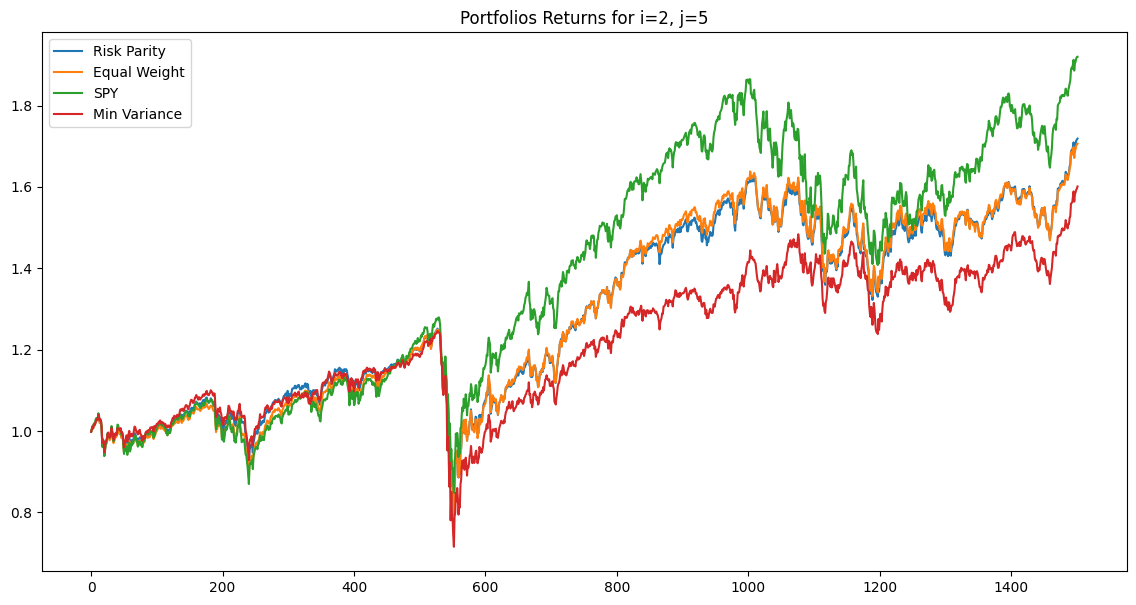

Annualized Returns, Volatility and Sharpe Ratio
Risk Parity: 9.51%, 19.05%, 0.50
Equal Weight: 9.38%, 19.41%, 0.48
SPY: 11.56%, 20.42%, 0.57
Min Variance: 8.22%, 18.92%, 0.43


In [120]:
start_date = '2018-01-01' #le spmo a des returns nuls trop souvent avant (manque de données sans doute)
end_date = '2023-12-31'
tickers = ['SPHQ', 'IVE', 'SPYD', 'SPLV', 'SPMO']
i=2
j=5
k=i
metrics_erc = rolling_rp_optimization(i=i, j=j, k=k, start_date=start_date, end_date=end_date, tickers=tickers)
metrics_ew = rolling_equal_weight_BT(i=i, j=j, k=k, start_date=start_date, end_date=end_date, tickers=tickers)
metrics_spy = rolling_backtest_SPY(i=i, j=j, k=k, start_date=start_date, end_date=end_date)
metrics_min_var = rolling_min_var_optimization(i=i, j=j, k=k, start_date=start_date, end_date=end_date, tickers=tickers)

cum_returns_erc = (1+metrics_erc[1]).cumprod()
cum_returns_ew = (1+metrics_ew[1]).cumprod()
cum_returns_spy = (1+metrics_spy[1]).cumprod()
cum_returns_min_var = (1+metrics_min_var[1]).cumprod()

plt.figure(figsize=(14, 7))
plt.plot(cum_returns_erc, label='Risk Parity')
plt.plot(cum_returns_ew, label='Equal Weight')
plt.plot(cum_returns_spy, label='SPY')
plt.plot(cum_returns_min_var, label='Min Variance')
plt.legend()
plt.title(f'Portfolios Returns for i={i}, j={j}')
plt.show()

periods_per_year = 252

print("Annualized Returns, Volatility and Sharpe Ratio")
ann_returns_erc = cum_returns_erc[-1]**(periods_per_year / len(cum_returns_erc)) - 1
ann_vol_erc = np.std(metrics_erc[1]) * np.sqrt(periods_per_year)
sharpe_erc = ann_returns_erc / ann_vol_erc
print(f"Risk Parity: {ann_returns_erc:.2%}, {ann_vol_erc:.2%}, {sharpe_erc:.2f}")

ann_returns_ew = cum_returns_ew[-1]**(periods_per_year / len(cum_returns_ew)) - 1
ann_vol_ew = np.std(metrics_ew[1]) * np.sqrt(periods_per_year)
sharpe_ew = ann_returns_ew / ann_vol_ew
print(f"Equal Weight: {ann_returns_ew:.2%}, {ann_vol_ew:.2%}, {sharpe_ew:.2f}")

ann_returns_spy = cum_returns_spy[-1]**(periods_per_year / len(cum_returns_spy)) - 1
ann_vol_spy = np.std(metrics_spy[1]) * np.sqrt(periods_per_year)
sharpe_spy = ann_returns_spy / ann_vol_spy
print(f"SPY: {ann_returns_spy:.2%}, {ann_vol_spy:.2%}, {sharpe_spy:.2f}")

ann_returns_min_var = cum_returns_min_var[-1]**(periods_per_year / len(cum_returns_min_var)) - 1
ann_vol_min_var = np.std(metrics_min_var[1]) * np.sqrt(periods_per_year)
sharpe_min_var = ann_returns_min_var / ann_vol_min_var
print(f"Min Variance: {ann_returns_min_var:.2%}, {ann_vol_min_var:.2%}, {sharpe_min_var:.2f}")

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite

[                       0%                       ]

You must convert self.cov to a positive definite matrix


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-116-36c3e6b70be9>:51: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  expected_annual_return = float(portfolio_returns.mean() * 252)
<ipython-input-116-36c3e6b70be9>:52: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  annual_volatility = float(portfolio_returns.std() * np.sqrt(252))
<ipython-input-116-36c3e6b70be9>:54: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cumulative_return = float((1 + portfolio_returns).prod() - 1)


Données récupérées avec succès.
Initialisation terminée.


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed

Calcul des métriques terminé.
Métriques converties en DataFrame.


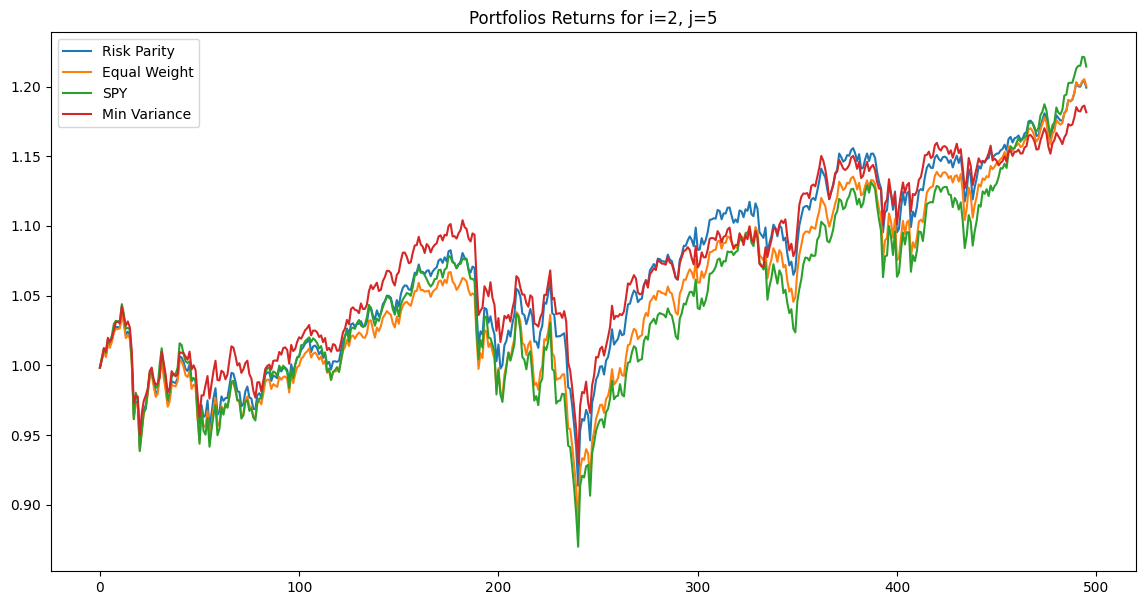

Annualized Returns, Volatility and Sharpe Ratio
Risk Parity: 9.67%, 12.83%, 0.75
Equal Weight: 9.73%, 13.31%, 0.73
SPY: 10.37%, 15.03%, 0.69
Min Variance: 8.84%, 12.00%, 0.74


In [121]:
start_date = '2018-01-01' #le spmo a des returns nuls trop souvent avant (manque de données sans doute)
end_date = '2019-12-31'
tickers = ['SPHQ', 'IVE', 'SPYD', 'SPLV', 'SPMO']
i=2
j=5
k=i
metrics_erc = rolling_rp_optimization(i=i, j=j, k=k, start_date=start_date, end_date=end_date, tickers=tickers)
metrics_ew = rolling_equal_weight_BT(i=i, j=j, k=k, start_date=start_date, end_date=end_date, tickers=tickers)
metrics_spy = rolling_backtest_SPY(i=i, j=j, k=k, start_date=start_date, end_date=end_date)
metrics_min_var = rolling_min_var_optimization(i=i, j=j, k=k, start_date=start_date, end_date=end_date, tickers=tickers)

cum_returns_erc = (1+metrics_erc[1]).cumprod()
cum_returns_ew = (1+metrics_ew[1]).cumprod()
cum_returns_spy = (1+metrics_spy[1]).cumprod()
cum_returns_min_var = (1+metrics_min_var[1]).cumprod()

plt.figure(figsize=(14, 7))
plt.plot(cum_returns_erc, label='Risk Parity')
plt.plot(cum_returns_ew, label='Equal Weight')
plt.plot(cum_returns_spy, label='SPY')
plt.plot(cum_returns_min_var, label='Min Variance')
plt.legend()
plt.title(f'Portfolios Returns for i={i}, j={j}')
plt.show()

periods_per_year = 252

print("Annualized Returns, Volatility and Sharpe Ratio")
ann_returns_erc = cum_returns_erc[-1]**(periods_per_year / len(cum_returns_erc)) - 1
ann_vol_erc = np.std(metrics_erc[1]) * np.sqrt(periods_per_year)
sharpe_erc = ann_returns_erc / ann_vol_erc
print(f"Risk Parity: {ann_returns_erc:.2%}, {ann_vol_erc:.2%}, {sharpe_erc:.2f}")

ann_returns_ew = cum_returns_ew[-1]**(periods_per_year / len(cum_returns_ew)) - 1
ann_vol_ew = np.std(metrics_ew[1]) * np.sqrt(periods_per_year)
sharpe_ew = ann_returns_ew / ann_vol_ew
print(f"Equal Weight: {ann_returns_ew:.2%}, {ann_vol_ew:.2%}, {sharpe_ew:.2f}")

ann_returns_spy = cum_returns_spy[-1]**(periods_per_year / len(cum_returns_spy)) - 1
ann_vol_spy = np.std(metrics_spy[1]) * np.sqrt(periods_per_year)
sharpe_spy = ann_returns_spy / ann_vol_spy
print(f"SPY: {ann_returns_spy:.2%}, {ann_vol_spy:.2%}, {sharpe_spy:.2f}")

ann_returns_min_var = cum_returns_min_var[-1]**(periods_per_year / len(cum_returns_min_var)) - 1
ann_vol_min_var = np.std(metrics_min_var[1]) * np.sqrt(periods_per_year)
sharpe_min_var = ann_returns_min_var / ann_vol_min_var
print(f"Min Variance: {ann_returns_min_var:.2%}, {ann_vol_min_var:.2%}, {sharpe_min_var:.2f}")

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-116-36c3e6b70be9>:51: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  expected_annual_return = float(portfolio_returns.mean() * 252)
<ipython-input-116-36c3e6b70be9>:52: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  annual_volatility = float(portfolio_returns.std() * np.sqrt(252))
<ipython-input-116-36c3e6b70be9>:54: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cumulative_return = float((1 + portfolio_returns).prod() - 1)


Données récupérées avec succès.
Initialisation terminée.


[*********************100%***********************]  5 of 5 completed

Calcul des métriques terminé.
Métriques converties en DataFrame.



[*********************100%***********************]  1 of 1 completed


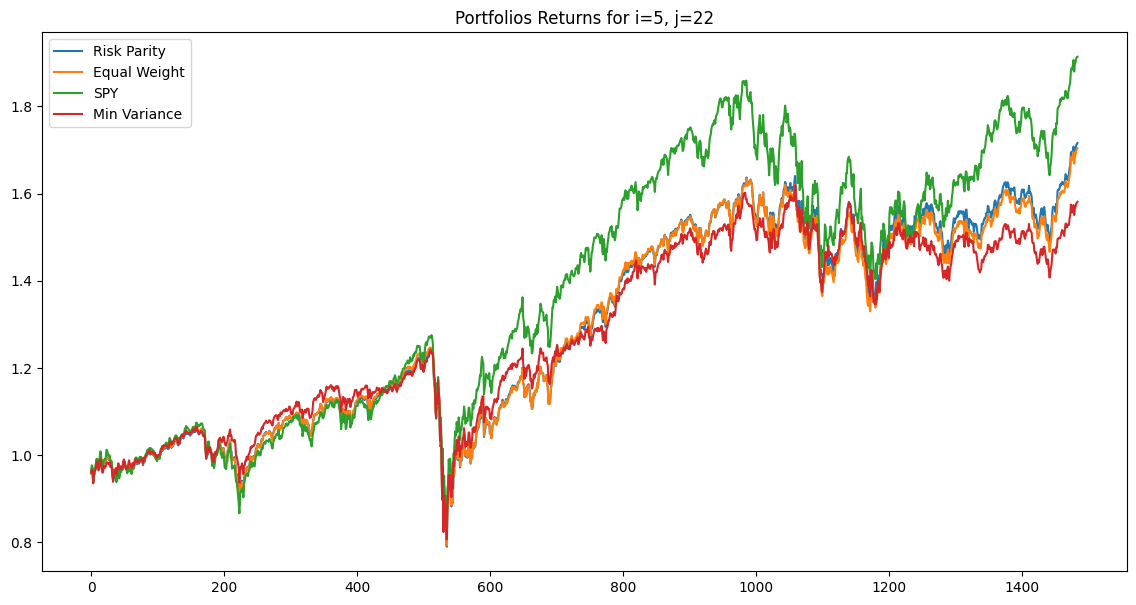

Annualized Returns, Volatility and Sharpe Ratio
Risk Parity: 9.60%, 19.16%, 0.50
Equal Weight: 9.46%, 19.49%, 0.49
SPY: 11.64%, 20.49%, 0.57
Min Variance: 8.08%, 18.72%, 0.43


In [122]:
start_date = '2018-01-01' #le spmo a des returns nuls trop souvent avant (manque de données sans doute)
end_date = '2023-12-31'
tickers = ['SPHQ', 'IVE', 'SPYD', 'SPLV', 'SPMO']
i=5
j=22
k=i
metrics_erc = rolling_rp_optimization(i=i, j=j, k=k, start_date=start_date, end_date=end_date, tickers=tickers)
metrics_ew = rolling_equal_weight_BT(i=i, j=j, k=k, start_date=start_date, end_date=end_date, tickers=tickers)
metrics_spy = rolling_backtest_SPY(i=i, j=j, k=k, start_date=start_date, end_date=end_date)
metrics_min_var = rolling_min_var_optimization(i=i, j=j, k=k, start_date=start_date, end_date=end_date, tickers=tickers)

cum_returns_erc = (1+metrics_erc[1]).cumprod()
cum_returns_ew = (1+metrics_ew[1]).cumprod()
cum_returns_spy = (1+metrics_spy[1]).cumprod()
cum_returns_min_var = (1+metrics_min_var[1]).cumprod()

plt.figure(figsize=(14, 7))
plt.plot(cum_returns_erc, label='Risk Parity')
plt.plot(cum_returns_ew, label='Equal Weight')
plt.plot(cum_returns_spy, label='SPY')
plt.plot(cum_returns_min_var, label='Min Variance')
plt.legend()
plt.title(f'Portfolios Returns for i={i}, j={j}')
plt.show()

periods_per_year = 252

print("Annualized Returns, Volatility and Sharpe Ratio")
ann_returns_erc = cum_returns_erc[-1]**(periods_per_year / len(cum_returns_erc)) - 1
ann_vol_erc = np.std(metrics_erc[1]) * np.sqrt(periods_per_year)
sharpe_erc = ann_returns_erc / ann_vol_erc
print(f"Risk Parity: {ann_returns_erc:.2%}, {ann_vol_erc:.2%}, {sharpe_erc:.2f}")

ann_returns_ew = cum_returns_ew[-1]**(periods_per_year / len(cum_returns_ew)) - 1
ann_vol_ew = np.std(metrics_ew[1]) * np.sqrt(periods_per_year)
sharpe_ew = ann_returns_ew / ann_vol_ew
print(f"Equal Weight: {ann_returns_ew:.2%}, {ann_vol_ew:.2%}, {sharpe_ew:.2f}")

ann_returns_spy = cum_returns_spy[-1]**(periods_per_year / len(cum_returns_spy)) - 1
ann_vol_spy = np.std(metrics_spy[1]) * np.sqrt(periods_per_year)
sharpe_spy = ann_returns_spy / ann_vol_spy
print(f"SPY: {ann_returns_spy:.2%}, {ann_vol_spy:.2%}, {sharpe_spy:.2f}")

ann_returns_min_var = cum_returns_min_var[-1]**(periods_per_year / len(cum_returns_min_var)) - 1
ann_vol_min_var = np.std(metrics_min_var[1]) * np.sqrt(periods_per_year)
sharpe_min_var = ann_returns_min_var / ann_vol_min_var
print(f"Min Variance: {ann_returns_min_var:.2%}, {ann_vol_min_var:.2%}, {sharpe_min_var:.2f}")

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix


/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-116-36c3e6b70be9>:51: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  expected_annual_return = float(portfolio_returns.mean() * 252)
<ipython-input-116-36c3e6b70be9>:52: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  annual_volatility = float(portfolio_returns.std() * np.sqrt(252))
<ipython-input-116-36c3e6b70be9>:54: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cumulative_return = float((1 + portfolio_returns).prod() - 1)


Données récupérées avec succès.
Initialisation terminée.
Calcul des métriques terminé.
Métriques converties en DataFrame.


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


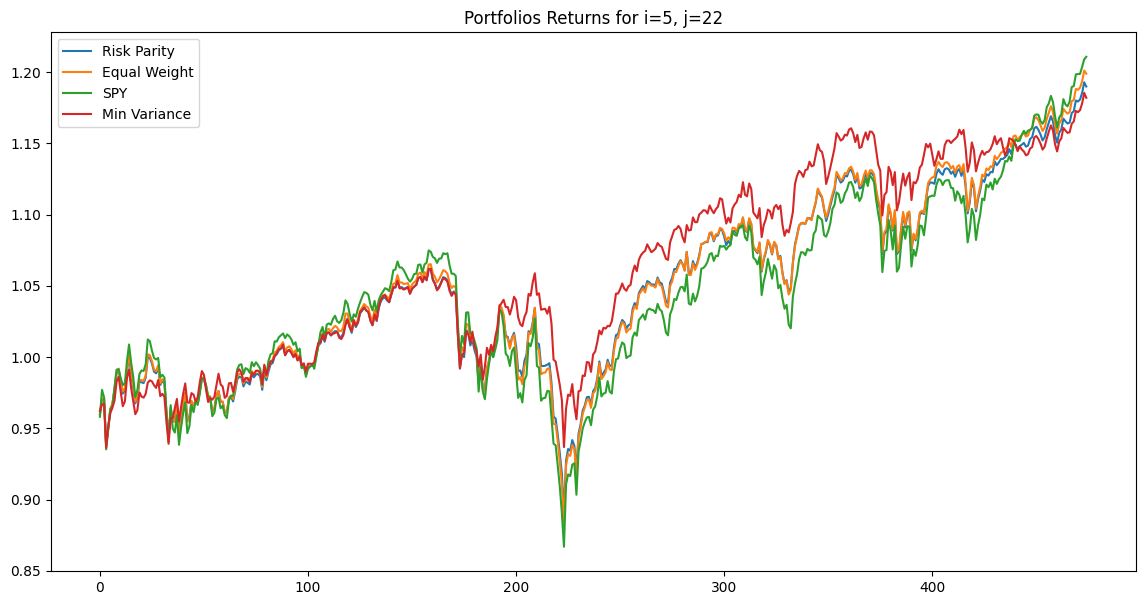

Annualized Returns, Volatility and Sharpe Ratio
Risk Parity: 9.67%, 12.95%, 0.75
Equal Weight: 10.10%, 13.44%, 0.75
SPY: 10.68%, 15.16%, 0.70
Min Variance: 9.28%, 11.71%, 0.79


In [123]:
start_date = '2018-01-01' #le spmo a des returns nuls trop souvent avant (manque de données sans doute)
end_date = '2019-12-31'
tickers = ['SPHQ', 'IVE', 'SPYD', 'SPLV', 'SPMO']
i=5
j=22
k=i
metrics_erc = rolling_rp_optimization(i=i, j=j, k=k, start_date=start_date, end_date=end_date, tickers=tickers)
metrics_ew = rolling_equal_weight_BT(i=i, j=j, k=k, start_date=start_date, end_date=end_date, tickers=tickers)
metrics_spy = rolling_backtest_SPY(i=i, j=j, k=k, start_date=start_date, end_date=end_date)
metrics_min_var = rolling_min_var_optimization(i=i, j=j, k=k, start_date=start_date, end_date=end_date, tickers=tickers)

cum_returns_erc = (1+metrics_erc[1]).cumprod()
cum_returns_ew = (1+metrics_ew[1]).cumprod()
cum_returns_spy = (1+metrics_spy[1]).cumprod()
cum_returns_min_var = (1+metrics_min_var[1]).cumprod()

plt.figure(figsize=(14, 7))
plt.plot(cum_returns_erc, label='Risk Parity')
plt.plot(cum_returns_ew, label='Equal Weight')
plt.plot(cum_returns_spy, label='SPY')
plt.plot(cum_returns_min_var, label='Min Variance')
plt.legend()
plt.title(f'Portfolios Returns for i={i}, j={j}')
plt.show()

periods_per_year = 252

print("Annualized Returns, Volatility and Sharpe Ratio")
ann_returns_erc = cum_returns_erc[-1]**(periods_per_year / len(cum_returns_erc)) - 1
ann_vol_erc = np.std(metrics_erc[1]) * np.sqrt(periods_per_year)
sharpe_erc = ann_returns_erc / ann_vol_erc
print(f"Risk Parity: {ann_returns_erc:.2%}, {ann_vol_erc:.2%}, {sharpe_erc:.2f}")

ann_returns_ew = cum_returns_ew[-1]**(periods_per_year / len(cum_returns_ew)) - 1
ann_vol_ew = np.std(metrics_ew[1]) * np.sqrt(periods_per_year)
sharpe_ew = ann_returns_ew / ann_vol_ew
print(f"Equal Weight: {ann_returns_ew:.2%}, {ann_vol_ew:.2%}, {sharpe_ew:.2f}")

ann_returns_spy = cum_returns_spy[-1]**(periods_per_year / len(cum_returns_spy)) - 1
ann_vol_spy = np.std(metrics_spy[1]) * np.sqrt(periods_per_year)
sharpe_spy = ann_returns_spy / ann_vol_spy
print(f"SPY: {ann_returns_spy:.2%}, {ann_vol_spy:.2%}, {sharpe_spy:.2f}")

ann_returns_min_var = cum_returns_min_var[-1]**(periods_per_year / len(cum_returns_min_var)) - 1
ann_vol_min_var = np.std(metrics_min_var[1]) * np.sqrt(periods_per_year)
sharpe_min_var = ann_returns_min_var / ann_vol_min_var
print(f"Min Variance: {ann_returns_min_var:.2%}, {ann_vol_min_var:.2%}, {sharpe_min_var:.2f}")

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-116-36c3e6b70be9>:51: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  expected_annual_return = float(portfolio_returns.mean() * 252)
<ipython-input-116-36c3e6b70be9>:52: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  annual_volatility = float(portfolio_returns.std() * np.sqrt(252))
<ipython-input-116-36c3e6b70be9>:54: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cumulative_return = float((1 + portfolio_returns).prod() - 1)


Données récupérées avec succès.
Initialisation terminée.
Calcul des métriques terminé.
Métriques converties en DataFrame.


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


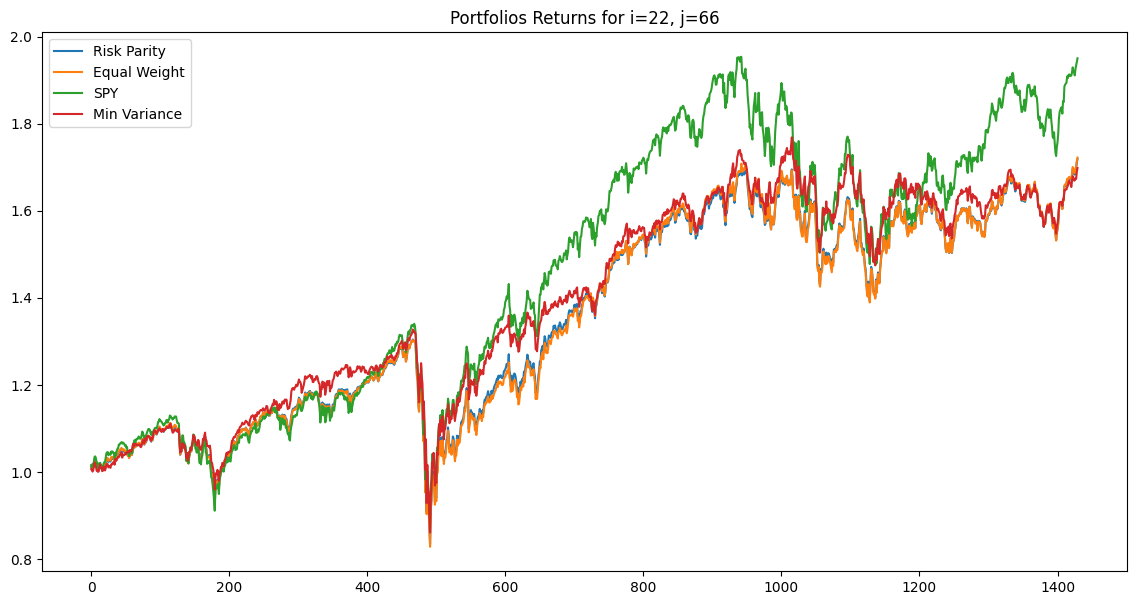

Annualized Returns, Volatility and Sharpe Ratio
Risk Parity: 10.01%, 19.19%, 0.52
Equal Weight: 10.05%, 19.48%, 0.52
SPY: 12.49%, 20.44%, 0.61
Min Variance: 9.78%, 18.21%, 0.54


In [124]:
start_date = '2018-01-01' #le spmo a des returns nuls trop souvent avant (manque de données sans doute)
end_date = '2023-12-31'
tickers = ['SPHQ', 'IVE', 'SPYD', 'SPLV', 'SPMO']
i=22
j=66
k=i
metrics_erc = rolling_rp_optimization(i=i, j=j, k=k, start_date=start_date, end_date=end_date, tickers=tickers)
metrics_ew = rolling_equal_weight_BT(i=i, j=j, k=k, start_date=start_date, end_date=end_date, tickers=tickers)
metrics_spy = rolling_backtest_SPY(i=i, j=j, k=k, start_date=start_date, end_date=end_date)
metrics_min_var = rolling_min_var_optimization(i=i, j=j, k=k, start_date=start_date, end_date=end_date, tickers=tickers)

cum_returns_erc = (1+metrics_erc[1]).cumprod()
cum_returns_ew = (1+metrics_ew[1]).cumprod()
cum_returns_spy = (1+metrics_spy[1]).cumprod()
cum_returns_min_var = (1+metrics_min_var[1]).cumprod()

plt.figure(figsize=(14, 7))
plt.plot(cum_returns_erc, label='Risk Parity')
plt.plot(cum_returns_ew, label='Equal Weight')
plt.plot(cum_returns_spy, label='SPY')
plt.plot(cum_returns_min_var, label='Min Variance')
plt.legend()
plt.title(f'Portfolios Returns for i={i}, j={j}')
plt.show()

periods_per_year = 252

print("Annualized Returns, Volatility and Sharpe Ratio")
ann_returns_erc = cum_returns_erc[-1]**(periods_per_year / len(cum_returns_erc)) - 1
ann_vol_erc = np.std(metrics_erc[1]) * np.sqrt(periods_per_year)
sharpe_erc = ann_returns_erc / ann_vol_erc
print(f"Risk Parity: {ann_returns_erc:.2%}, {ann_vol_erc:.2%}, {sharpe_erc:.2f}")

ann_returns_ew = cum_returns_ew[-1]**(periods_per_year / len(cum_returns_ew)) - 1
ann_vol_ew = np.std(metrics_ew[1]) * np.sqrt(periods_per_year)
sharpe_ew = ann_returns_ew / ann_vol_ew
print(f"Equal Weight: {ann_returns_ew:.2%}, {ann_vol_ew:.2%}, {sharpe_ew:.2f}")

ann_returns_spy = cum_returns_spy[-1]**(periods_per_year / len(cum_returns_spy)) - 1
ann_vol_spy = np.std(metrics_spy[1]) * np.sqrt(periods_per_year)
sharpe_spy = ann_returns_spy / ann_vol_spy
print(f"SPY: {ann_returns_spy:.2%}, {ann_vol_spy:.2%}, {sharpe_spy:.2f}")

ann_returns_min_var = cum_returns_min_var[-1]**(periods_per_year / len(cum_returns_min_var)) - 1
ann_vol_min_var = np.std(metrics_min_var[1]) * np.sqrt(periods_per_year)
sharpe_min_var = ann_returns_min_var / ann_vol_min_var
print(f"Min Variance: {ann_returns_min_var:.2%}, {ann_vol_min_var:.2%}, {sharpe_min_var:.2f}")

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-116-36c3e6b70be9>:51: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  expected_annual_return = float(portfolio_returns.mean() * 252)
<ipython-input-116-36c3e6b70be9>:52: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  annual_volatility = float(portfolio_returns.std() * np.sqrt(252))
<ipython-input-116-36c3e6b70be9>:54: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser

Données récupérées avec succès.
Initialisation terminée.
Calcul des métriques terminé.
Métriques converties en DataFrame.



[*********************100%***********************]  1 of 1 completed


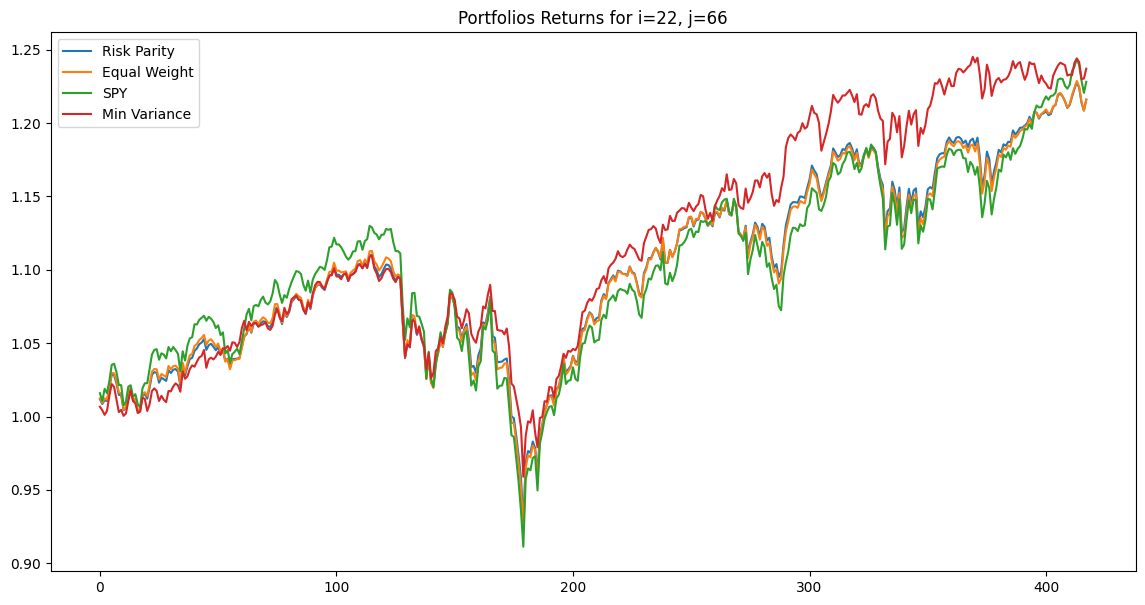

Annualized Returns, Volatility and Sharpe Ratio
Risk Parity: 12.50%, 12.01%, 1.04
Equal Weight: 12.51%, 12.54%, 1.00
SPY: 13.18%, 14.18%, 0.93
Min Variance: 13.68%, 10.73%, 1.27


In [125]:
start_date = '2018-01-01' #le spmo a des returns nuls trop souvent avant (manque de données sans doute)
end_date = '2019-12-31'
tickers = ['SPHQ', 'IVE', 'SPYD', 'SPLV', 'SPMO']
i=22
j=66
k=i
metrics_erc = rolling_rp_optimization(i=i, j=j, k=k, start_date=start_date, end_date=end_date, tickers=tickers)
metrics_ew = rolling_equal_weight_BT(i=i, j=j, k=k, start_date=start_date, end_date=end_date, tickers=tickers)
metrics_spy = rolling_backtest_SPY(i=i, j=j, k=k, start_date=start_date, end_date=end_date)
metrics_min_var = rolling_min_var_optimization(i=i, j=j, k=k, start_date=start_date, end_date=end_date, tickers=tickers)

cum_returns_erc = (1+metrics_erc[1]).cumprod()
cum_returns_ew = (1+metrics_ew[1]).cumprod()
cum_returns_spy = (1+metrics_spy[1]).cumprod()
cum_returns_min_var = (1+metrics_min_var[1]).cumprod()

plt.figure(figsize=(14, 7))
plt.plot(cum_returns_erc, label='Risk Parity')
plt.plot(cum_returns_ew, label='Equal Weight')
plt.plot(cum_returns_spy, label='SPY')
plt.plot(cum_returns_min_var, label='Min Variance')
plt.legend()
plt.title(f'Portfolios Returns for i={i}, j={j}')
plt.show()

periods_per_year = 252

print("Annualized Returns, Volatility and Sharpe Ratio")
ann_returns_erc = cum_returns_erc[-1]**(periods_per_year / len(cum_returns_erc)) - 1
ann_vol_erc = np.std(metrics_erc[1]) * np.sqrt(periods_per_year)
sharpe_erc = ann_returns_erc / ann_vol_erc
print(f"Risk Parity: {ann_returns_erc:.2%}, {ann_vol_erc:.2%}, {sharpe_erc:.2f}")

ann_returns_ew = cum_returns_ew[-1]**(periods_per_year / len(cum_returns_ew)) - 1
ann_vol_ew = np.std(metrics_ew[1]) * np.sqrt(periods_per_year)
sharpe_ew = ann_returns_ew / ann_vol_ew
print(f"Equal Weight: {ann_returns_ew:.2%}, {ann_vol_ew:.2%}, {sharpe_ew:.2f}")

ann_returns_spy = cum_returns_spy[-1]**(periods_per_year / len(cum_returns_spy)) - 1
ann_vol_spy = np.std(metrics_spy[1]) * np.sqrt(periods_per_year)
sharpe_spy = ann_returns_spy / ann_vol_spy
print(f"SPY: {ann_returns_spy:.2%}, {ann_vol_spy:.2%}, {sharpe_spy:.2f}")

ann_returns_min_var = cum_returns_min_var[-1]**(periods_per_year / len(cum_returns_min_var)) - 1
ann_vol_min_var = np.std(metrics_min_var[1]) * np.sqrt(periods_per_year)
sharpe_min_var = ann_returns_min_var / ann_vol_min_var
print(f"Min Variance: {ann_returns_min_var:.2%}, {ann_vol_min_var:.2%}, {sharpe_min_var:.2f}")